# Multi-armed bandits in ecommerce: search optimization

### 1. Многорукие бандиты

### 2. Поисковая оптимизация

### 3. Рекомендации фильмов


---------------------------------

# 1. Multi-armed bandits

* Только одно состояние $|S| = 1$
* Многорукий бандит — это кортеж из (A, R)
* A: известное множество из m действий (рычагов)
* $R^a(r) = P[r|a]$ — это неизвестное распределение вероятностей вознаграждений
* На каждом шаге t агент выбирает действие $a_t \in A$
* Окружение генерирует вознаграждение $r_t \sim R^a(r)$
* Цель: максимизировать накопленное вознаграждение $\sum_{t=1}^T r_t$


![title](img/mab.png)

* **Action-value** — это среднее вознаграждение за действие *a*  
  $$Q(a) = \mathbb{E}[r \mid a]$$

* **Optimal value** $V^*$ — наилучшее возможное среднее вознаграждение  
  $$V^* = Q(a^*) = \max_{a \in \mathcal{A}} Q(a)$$

* **Regret** — упущенная выгода за один шаг  
  $$l_t = \mathbb{E}[V^* - Q(a_t)]$$

* **Total Regret** — суммарная упущенная выгода  
  $$L_t = \mathbb{E}\left[\sum_{\tau=1}^{t} V^* - Q(a_\tau)\right]$$

* Максимизация накопленного вознаграждения ⟺ минимизация **total regret**


***
### *Q: What are the policies for multi-armed bandits?*
***

## Bernoulli Bandit

<img src=img/bandits_.png width="500">

Мы собираемся реализовать несколько стратегий исследования для самой простой задачи — бернуллиевского бандита.

Бандит имеет $K$ действий. Действие даёт вознаграждение 1.0 $r$ с вероятностью $0 \le \theta_k \le 1$, которая неизвестна агенту, но постоянна во времени. Цель агента — минимизировать regret (сожаление) за фиксированное число $T$ выборов действий:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

где $\theta^* = \max_k\{\theta_k\}$


In [1]:
import random

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
class BernoulliEnv:
    
    def __init__(self, arms_proba: list):
        self.arms_proba = arms_proba
        
    @property
    def n_arms(self):
        return len(self.arms_proba)
        
    def pull_arm(self, arm_id: int):
        if random.random() < self.arms_proba[arm_id]:
            return 1
        else:
            return 0    

In [3]:
class Strategy:
    
    def __init__(self, n_arms: int):
        self.n_arms = n_arms
        # self.n_iters = 0
        # self.arms_states = np.zeros(n_arms)    # награда за каждую ручку
        # self.arms_actions = np.zeros(n_arms)   # сколько раз выбрали каждую ручку
        self.reset()
        
    def reset(self):
        self.n_iters = 0
        self.arms_states = np.zeros(self.n_arms)
        self.arms_actions = np.zeros(self.n_arms)
        
    def update_reward(self, arm: int, reward: int):
        self.n_iters += 1
        self.arms_states[arm] += reward
        self.arms_actions[arm] += 1
        
    def choose_arm(self):
        raise NotImplementedError

## 1.1 Greedy policy (жадыный алгоритм)

### 1.1 Greedy policy (жадный алгоритм)

* Рассматриваем алгоритмы, оценивающие $\hat{Q}_t(a) \approx Q(a)$  
* Значение каждого действия оценивается через Монте-Карло (Monte-Carlo)
  - Оценка через Монте-Карло — это усреднение фактических полученных вознаграждений для каждого действия. То есть:

    пробуем действие несколько раз → запоминаем все полученные награды → берём среднее.

    Таким способом приближённо оцениваем, насколько хорошее действие.

$$
\hat{Q}_t(a) = \frac{1}{N_t(a)} \sum_{t=1}^{T} r_t \cdot \mathbf{1}(a_t = a)
$$

* **greedy**-алгоритм выбирает действие с максимальной оценкой

$$
a_t^* = \arg\max_{a \in \mathcal{A}} \hat{Q}_t(a)
$$

* Жадный алгоритм может застрять на неоптимальном действии навсегда

---

**Обозначения:**

- $r_t$ — вознаграждение на шаге *t*  
- $a_t$ — выбранное действие  
- $N_t(a)$ — сколько раз выбрано действие *a* к моменту *t*  
- $\hat{Q}_t(a)$ — оценка среднего вознаграждения действия *a*


In [4]:
class Greedy(Strategy):
    
    def __init__(self, n_arms: int, test_iters: int = 1000):
        super().__init__(n_arms)
        self.test_iters = test_iters
    
    def choose_arm(self):
        if self.n_iters < self.test_iters:
            return random.randint(0, self.n_arms - 1)
        else:
            return np.argmax(self.arms_states / self.arms_actions)

## 1.2 ε-greedy policy

* Алгоритм **ε-greedy** работает следующим образом:
  * С вероятностью $1 - \varepsilon$ выбираем действие  
    $$a_t = \arg\max_{a \in \mathcal{A}} \hat{Q}_t(a)$$
  * С вероятностью $\varepsilon$ выбираем случайное действие

* Всегда будет принимать неоптимальное решение в доле $\varepsilon$ времени


In [6]:
class EpsGreedy(Strategy):
    
    def __init__(self, n_arms: int, eps: float = 0.1):
        super().__init__(n_arms)
        self.eps = eps

        
    def choose_arm(self):
        if random.random() < self.eps:
            return random.randint(0, self.n_arms - 1)
        else:
            choose_array = np.nan_to_num(self.arms_states / self.arms_actions, nan=0.0)
            return np.argmax(choose_array) 

## 1.3 UCB1

Этапы алгоритма UCB1:

* Сыграть каждое из K действий по одному разу, чтобы получить начальные значения средних вознаграждений
* Для каждого раунда t = K:
* Пусть Nt(a) — это количество раз, когда действие a было выбрано на данный момент
* Выбрать действие at, максимизирующее следующее выражение:



Алгоритм UCB1 выбирает действие, максимизируя следующее:

$$
 \Huge Q(a) + \sqrt{\frac{2 \log t}{N_t(a)}}
$$

Где:  
- $Q(a)$ — среднее вознаграждение для действия *a*  
- $t$ — текущий шаг  
- $N_t(a)$ — сколько раз выбрано действие *a* до шага *t*

### Как это работает:
* Первый член ($Q(a)$) — **эксплуатация**: выбираем действия с хорошими средними наградами  
* Второй член (корень) — **исследование**: даёт преимущество тем действиям, которые пробовали мало раз

### Почему это работает:
* Если действие часто выбиралось, $\frac{1}{N_t(a)}$ становится маленьким → меньше стимулов его исследовать  
* Если действие почти не пробовалось, член исследования будет большим → больше шансов его выбрать  

Таким образом, формула балансирует между **исследованием** и **эксплуатацией**.


In [7]:
class UCB1(Strategy):
    
    def choose_arm(self):
        if self.n_iters < self.n_arms:
            return self.n_iters
        else:
            return np.argmax(self.ucb())
        
        
    def ucb(self):
        ucb = self.arms_states / self.arms_actions
        ucb += np.sqrt(2 * np.log(self.n_iters) / self.arms_actions)
        return ucb

## 1.4 Thompson sampling

### 1.4 Thompson sampling

Для бернуллиевского бандита естественно предположить, что $Q(a)$ следует бета-распределению (Beta), поскольку $Q(a)$ — это вероятность успеха $\theta$ в распределении Бернулли (Bernoulli). Значение Beta$(\alpha, \beta)$ лежит в интервале [0, 1]; параметры $\alpha$ и $\beta$ — это количества успешных и неуспешных попыток получить награду.

Сначала инициализируем параметры $\alpha$ и $\beta$ на основе некоторого предварительного знания или предположения для каждого действия. Например:

* $\alpha = 1$, $\beta = 1$: ожидаем вероятность награды 50%, но не уверены
* $\alpha = 1000$, $\beta = 9000$: сильно уверены, что вероятность награды 10%

На каждом шаге $t$:
* Сэмплируем ожидаемое вознаграждение $\tilde{Q}(a)$ из распределения Beta$(\alpha_i, \beta_i)$ для каждого действия
* Выбираем действие, максимизирующее сэмплированную оценку:

$$
\huge a_t^{TS} = \arg\max_{a \in \mathcal{A}} \tilde{Q}(a)
$$

После получения реальной награды обновляем параметры распределения:

$$
\alpha_i \leftarrow \alpha_i + r_t \cdot \mathbf{1}[a_t^{TS} = a_i]
$$

$$
\beta_i \leftarrow \beta_i + (1 - r_t) \cdot \mathbf{1}[a_t^{TS} = a_i]
$$

Это и есть байесовское обновление априорного распределения по наблюдаемым данным.


In [8]:
class Thompson(Strategy):
    
    def __init__(self, n_arms: int):
        super().__init__(n_arms)
        self.alphas = np.ones(self.n_arms)
        self.betas = np.ones(self.n_arms)
        
    def choose_arm(self):
        arm = np.argmax([np.random.beta(self.alphas[i], self.betas[i]) for i in range(self.n_arms)])
        return arm
        
    def update_reward(self, arm: int, reward: int):
        super().update_reward(arm, reward)
        self.alphas[arm] += reward
        self.betas[arm] += 1 - reward

## Agent

In [9]:
class Bandit:
    
    def __init__(self, env: BernoulliEnv, strategy: Strategy):
        self.env = env
        self.strategy = strategy
        
    def action(self):
        arm = self.strategy.choose_arm()
        reward = self.env.pull_arm(arm)
        self.strategy.update_reward(arm, reward) 

# Play and calculate regret

### setup environment and strategies

In [63]:
be = BernoulliEnv([0.3, 0.5, 0.7])

In [64]:
be.n_arms

3

In [65]:
greedy = Greedy(be.n_arms, 1000)
eps = EpsGreedy(be.n_arms, 0.04)
ucb = UCB1(be.n_arms)
thompson = Thompson(be.n_arms)

In [66]:
def calculate_regret(env: BernoulliEnv, strategy: Strategy, n_iters=20000):
    strategy.reset()
    bandit = Bandit(env, strategy)
    regrets = []
    for i in range(n_iters):
        reward = bandit.strategy.arms_actions.dot(env.arms_proba)    # награда текущая
        optimal_reward = np.max(env.arms_proba) * i    # оптимальная награда = максимальная * (№ итерации)
        regret = optimal_reward - reward
        regrets.append(regret)
        bandit.action()
        
    return regrets

### play episodes

In [67]:
greedy_regrets = calculate_regret(be, greedy)
eps_regrets = calculate_regret(be, eps)
ucb_regrets = calculate_regret(be, ucb)
thompson_regrets = calculate_regret(be, thompson)

C:\Users\BATMAN\AppData\Local\Temp\ipykernel_12260\3403883865.py:12: RuntimeWarning: invalid value encountered in divide
  choose_array = np.nan_to_num(self.arms_states / self.arms_actions, nan=0.0)


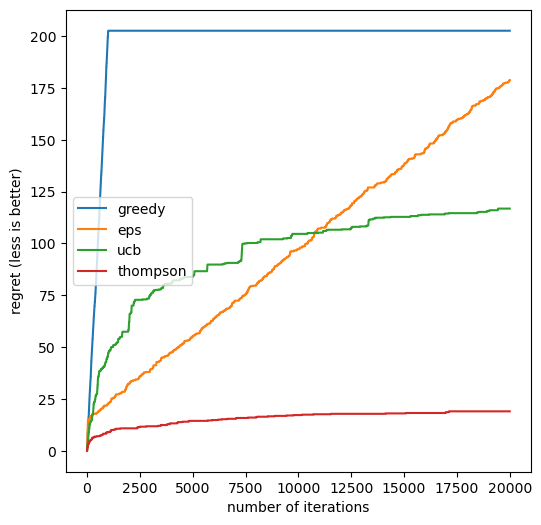

In [68]:
plt.figure(figsize=(6, 6))
plt.plot(greedy_regrets, label='greedy')
plt.plot(eps_regrets, label='eps')
plt.plot(ucb_regrets, label='ucb')
plt.plot(thompson_regrets, label='thompson')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('regret (less is better)');

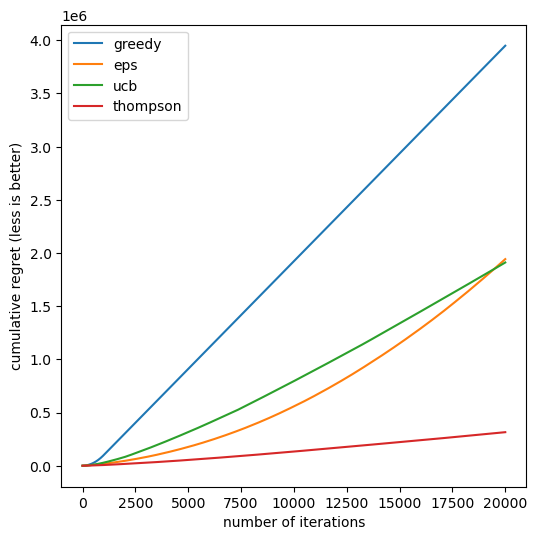

In [70]:
plt.figure(figsize=(6, 6))
plt.plot(np.cumsum(greedy_regrets), label='greedy')
plt.plot(np.cumsum(eps_regrets), label='eps')
plt.plot(np.cumsum(ucb_regrets), label='ucb')
plt.plot(np.cumsum(thompson_regrets), label='thompson')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('cumulative regret (less is better)');

In [40]:
greedy = Greedy(be.n_arms, 1000)
eps = EpsGreedy(be.n_arms, 0.001)
ucb = UCB1(be.n_arms)
thompson = Thompson(be.n_arms)

In [71]:
greedy_regrets = calculate_regret(be, greedy)
eps_regrets = calculate_regret(be, eps)
ucb_regrets = calculate_regret(be, ucb)
thompson_regrets = calculate_regret(be, thompson)

C:\Users\BATMAN\AppData\Local\Temp\ipykernel_12260\3403883865.py:12: RuntimeWarning: invalid value encountered in divide
  choose_array = np.nan_to_num(self.arms_states / self.arms_actions, nan=0.0)


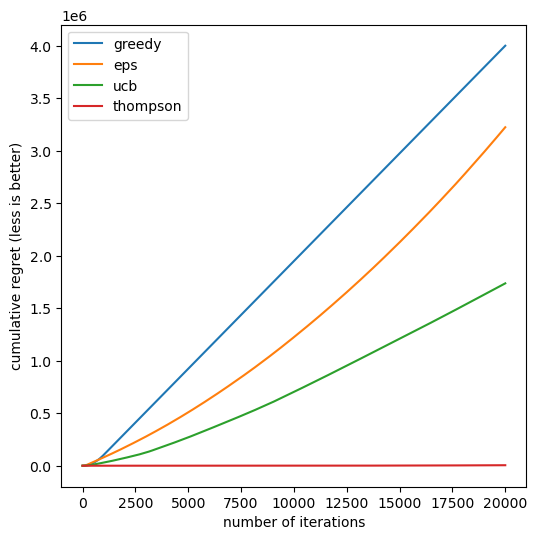

In [72]:
plt.figure(figsize=(6, 6))
plt.plot(np.cumsum(greedy_regrets), label='greedy')
plt.plot(np.cumsum(eps_regrets), label='eps')
plt.plot(np.cumsum(ucb_regrets), label='ucb')
plt.plot(np.cumsum(thompson_regrets), label='thompson')
plt.legend()
plt.xlabel('number of iterations')
plt.ylabel('cumulative regret (less is better)');

# 2. Search optimization
## Ranked Bandits Algorithm

https://www.cs.cornell.edu/people/tj/publications/radlinski_etal_08a.pdf

http://ceur-ws.org/Vol-2410/paper18.pdf

https://github.com/alison-carrera/mabalgs

<img src=img/kettle.png width="500">

 Мы рассматриваем задачу обучения оптимально диверсифицированному ранжированию документов  
$\mathcal{D} = \{d_1, \dots, d_n\}$ для одного фиксированного запроса.

В момент времени $t$ мы взаимодействуем с пользователем $u_t$, которому соответствует релевантное множество $A_t$.  
Мы показываем упорядоченное множество из $k$ документов  
$B_t = (b_1(t), \dots, b_k(t))$.  
Пользователь просматривает результаты по порядку и может кликнуть максимум по одному документу.

Мы получаем выплату 1, если пользователь кликнул, и 0 — если нет.  
Цель — максимизировать суммарную выплату по всем временным шагам.

---

**Q: Как решить эту задачу с помощью многоруких бандитов?**


![title](img/rba_algo.png)

### Алгоритм Ranked Bandits — краткое описание

Алгоритм используется для выбора и ранжирования $k$ документов для пользователя с целью максимизации кликов.

---

#### 🔧 Инициализация:
- Создаём $k$ отдельных многоруких бандитов (MAB): по одному для каждой позиции в ранжировании.

---

#### 🔁 Основной цикл (по времени $t$):

1. **Выбор документов:**
   - Для каждой позиции $i = 1 \dots k$:
     - Выбираем документ $\hat{b}_i(t)$ с помощью $MAB_i$
     - Если он уже выбран ранее (в позициях $1, \dots, i-1$), то выбираем случайный неповторяющийся документ
     - Добавляем итоговый $b_i(t)$ в отображаемый список

2. **Показ пользователю:**
   - Показываем упорядоченный список документов $\{b_1(t), \dots, b_k(t)\}$
   - Пользователь кликает максимум по одному документу

3. **Обновление бандитов:**
   - Для каждой позиции $i$:
     - Если пользователь кликнул именно $b_i(t)$ и он совпал с предложенным $\hat{b}_i(t)$:
       - Считаем это **успехом** ($f_i(t) = 1$)
     - Иначе — **неудача** ($f_i(t) = 0$)
     - Обновляем $MAB_i$ с этим результатом

---

#### 💡 Суть:
Каждый бандит обучается, какие документы лучше предлагать **на своей позиции**, чтобы получить клик.  
Это позволяет адаптивно формировать **эффективное ранжирование с учётом позиции**.


In [82]:
from mab import algs, simulator

In [83]:
class RBA:
    """
        Этот класс представляет реализацию алгоритма Ranked Multi-Armed Bandit (ранговый MAB).
    """

    def __init__(self, n_arms, n_ranks, mab_algorithm_class):
        """
            Конструктор RBA.

            :param n_arms: Количество рычагов (arms), с которыми будет работать RBA.
            :param n_ranks: Количество позиций ранжирования (ranks).
            :param mab_algorithm_class: Класс алгоритма MAB, который будет использоваться.
        """
        self.n_ranks = n_ranks
        self.mab_alg_type = mab_algorithm_class
        self.original_arms = set(list(range(n_arms)))
        self.ranks = []

        for i in range(n_ranks):
            self.ranks.append(mab_algorithm_class(n_arms))

    def resolve_conflict(self, selected_arms, optional_elements):
        """
            Этот метод отвечает за разрешение конфликтов между MAB'ами на разных позициях.

            :param selected_arms: Уже выбранные рычаги (arms).
            :param optional_elements: Дополнительные данные, которые могут понадобиться для разрешения конфликта.

            :return: Возвращает выбранный arm после устранения конфликта.
        """
        available_arms = self.original_arms - set(selected_arms)
        return random.choice(list(available_arms))

    def select(self):
        """
            Этот метод выбирает рычаги (arms) для всех позиций (ranks).

            :return: Возвращает список выбранных arm'ов для каждой позиции.
        """
        selected_arms = []

        for i in range(self.n_ranks):
            selected_arm, ranked_arms = self.ranks[i].select()

            if selected_arm in selected_arms:
                selected_arms.append(self.resolve_conflict(
                    selected_arms, ranked_arms))
            else:
                selected_arms.append(selected_arm)

        return selected_arms

    def reward(self, selected_arms, chosen_arm):
        """
            Этот метод отвечает за выдачу награды выбранному arm'у в RBA.

            :param selected_arms: Выбранные arm'ы, которые показали пользователю.
            :param chosen_arm: Arm, на который кликнул пользователь.
        """
        for arm in selected_arms:
            rank_index = selected_arms.index(arm)
            if arm == chosen_arm:
                self.ranks[rank_index].reward(arm)


In [84]:
def plot_results_proba(algorithm_name, array_result):
    row = 2
    column = 2

    fig, ax = plt.subplots(row, column, figsize=(20, 10))
    fig.suptitle('Performance of RBAM using {}'.format(algorithm_name))

    rank_value = 0

    for i in range(row):
        for j in range(column):
            ax[i, j].plot(range(array_result[1]), array_result[2][rank_value][:,0], label='0')
            ax[i, j].plot(range(array_result[1]), array_result[2][rank_value][:,1], label='1')
            ax[i, j].plot(range(array_result[1]), array_result[2][rank_value][:,2], label='2')
            ax[i, j].plot(range(array_result[1]), array_result[2][rank_value][:,3], label='3')
            ax[i, j].plot(range(array_result[1]), array_result[2][rank_value][:,4], label='4')
            ax[i, j].legend()
            ax[i, j].set_title('Rank {} Performance'.format(rank_value + 1))
            ax[i, j].set_xlabel('Time')
            ax[i, j].set_ylabel('Probability of select an arm')
            ax[i, j].set_ylim(0.0, 1.0)

            rank_value += 1

    fig.tight_layout()
    fig.subplots_adjust(top=0.88)


    plt.show()

def plot_result_rewards(result_ucb, result_ths, result_tuned):
    plt.title('Cumulative rewards of RBAM UCB1 vs Thompson Sampling vs UCB Tuned')
    plt.xlabel('Time')
    plt.ylabel('Rewards')
    plt.plot(range(result_ucb[1]), result_ucb[3], label='UCB1')
    plt.plot(range(result_ths[1]), result_ths[3], label='THS')
    plt.plot(range(result_tuned[1]), result_tuned[3], label='UCB Tuned')
    plt.legend()
    plt.grid(True)

    plt.show()


**Пример:**  
Мы хотим протестировать MAB с 5 рычагами (arms) и 4 позициями ранжирования (ranks),  
который будет использоваться в задаче поиска.  

Задача MAB — выбрать, какие 4 документа из 5 следует показать пользователю,  
чтобы получить максимальное количество кликов — с учётом **позиции показа** (slot position),  
так как пользователи чаще кликают по верхним позициям.


В этой симуляции есть особенность:  
в каждый момент времени мы задаём вероятность клика для всех доступных arm'ов на **каждой позиции ранжирования**,  
а последний массив — это вероятность клика на данной позиции (скорость сходимости в зависимости от позиции).

Общая продолжительность симуляции — **3000 шагов**,  
каждая точка на графике — это **среднее значение по 1000 симуляциям**,  
каждая из которых длится 3000 шагов.

Из словаря можно сделать вывод:

- **С момента 0 до 1500:**
  - Победитель на позиции 0 — arm 3  
  - Победитель на позиции 1 — arm 2  
  - Победитель на позиции 2 — arm 1  
  - Победитель на позиции 3 — arm 0  

- **С момента 1500 до 3000:**
  - Победитель на позиции 0 — arm 0  
  - Победитель на позиции 1 — arm 1  
  - Победитель на позиции 2 — arm 2  
  - Победитель на позиции 3 — arm 3  

Вероятность клика для всех позиций одинаковая — это сделано для более наглядного сравнения поведения алгоритмов.


In [85]:
%%time
reward_probabilities = {0: [[0.1, 0.1, 0.1, 0.9, 0.1], 
                            [0.1, 0.1, 0.9, 0.1, 0.1], 
                            [0.1, 0.9, 0.1, 0.1, 0.1], 
                            [0.9, 0.1, 0.1, 0.1, 0.1], 
                            [0.25, 0.25, 0.25, 0.25]],
                        
                       1500: [[0.9, 0.1, 0.1, 0.1, 0.1], 
                             [0.1, 0.9, 0.1, 0.1, 0.1], 
                             [0.1, 0.1, 0.9, 0.1, 0.1], 
                             [0.1, 0.1, 0.1, 0.9, 0.1], 
                             [0.25, 0.25, 0.25, 0.25]]} #Rank weight.

number_of_pulls = 3000
number_of_simulation = 100

mcs = simulator.RankedMonteCarloSimulator()
results_ths = mcs.run("rba", algs.ThompsomSampling, reward_probabilities, number_of_simulation, number_of_pulls)
results_ucb1 = mcs.run("rba", algs.UCB1, reward_probabilities, number_of_simulation, number_of_pulls)

CPU times: total: 51.1 s
Wall time: 51.1 s


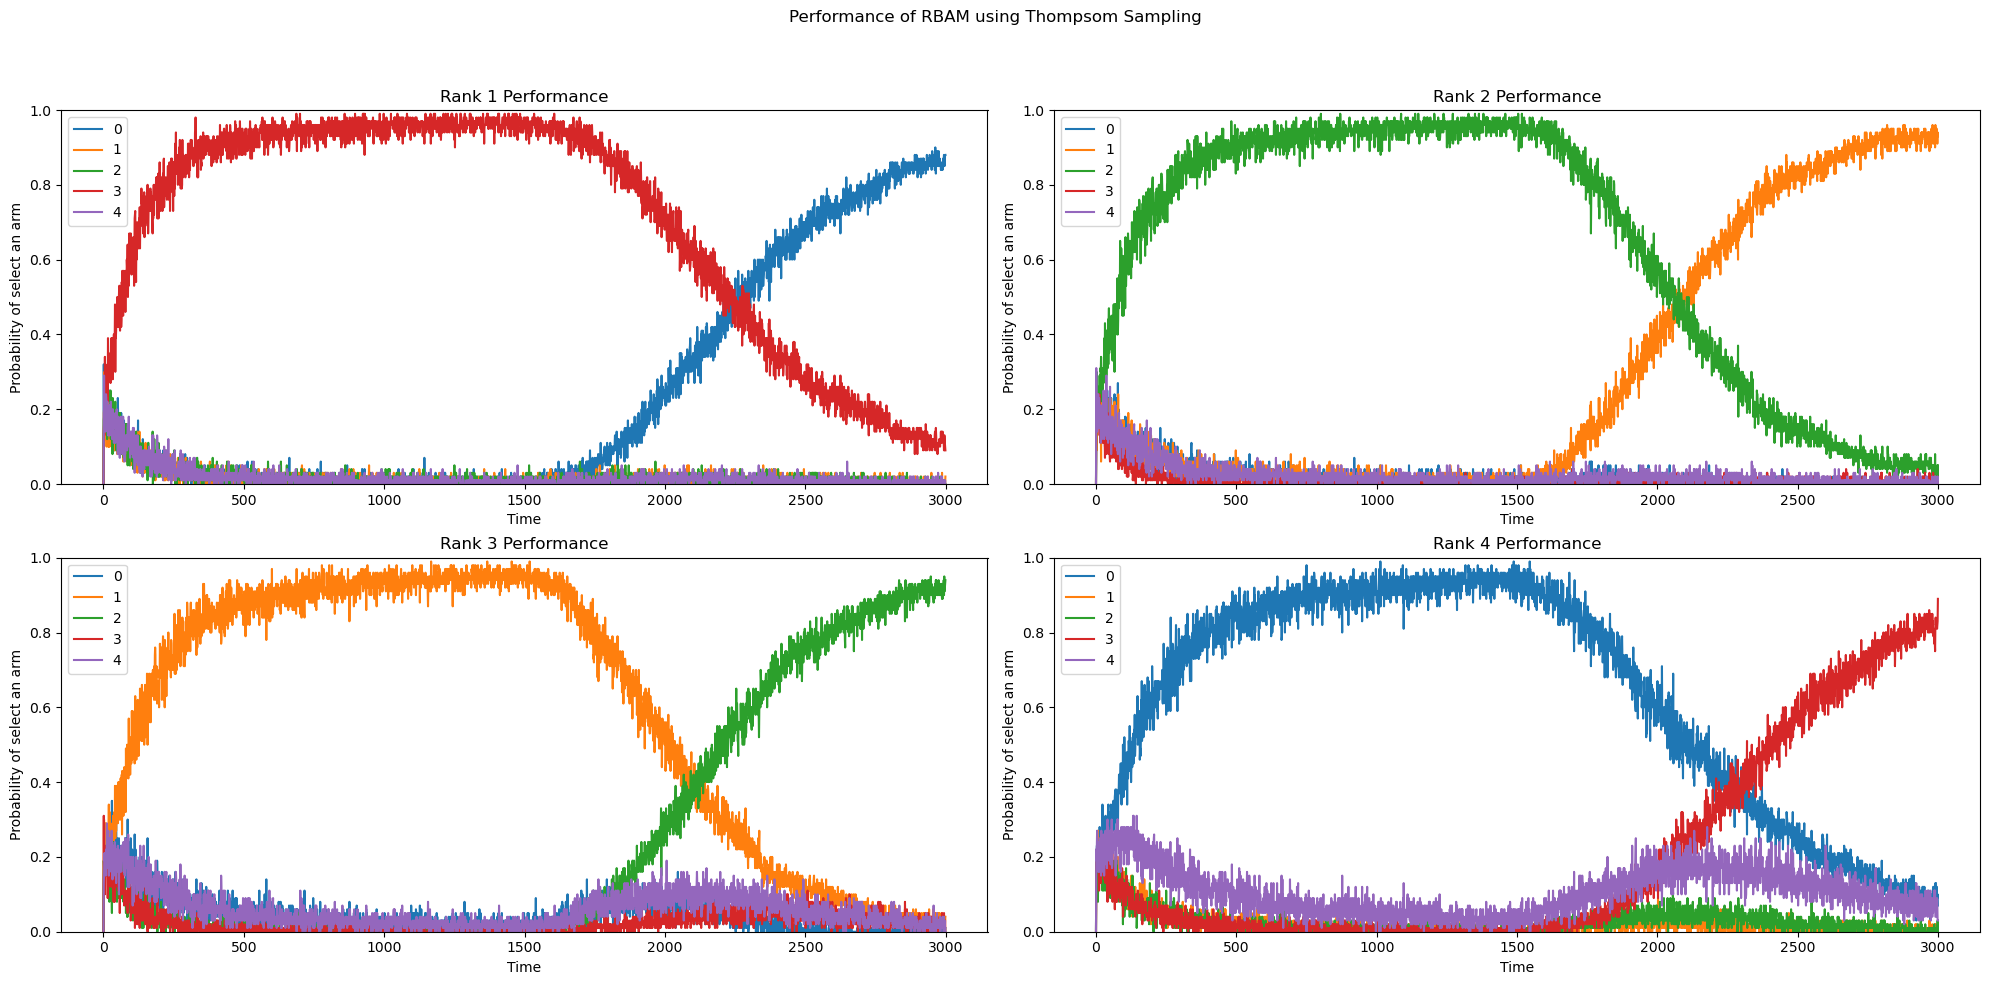

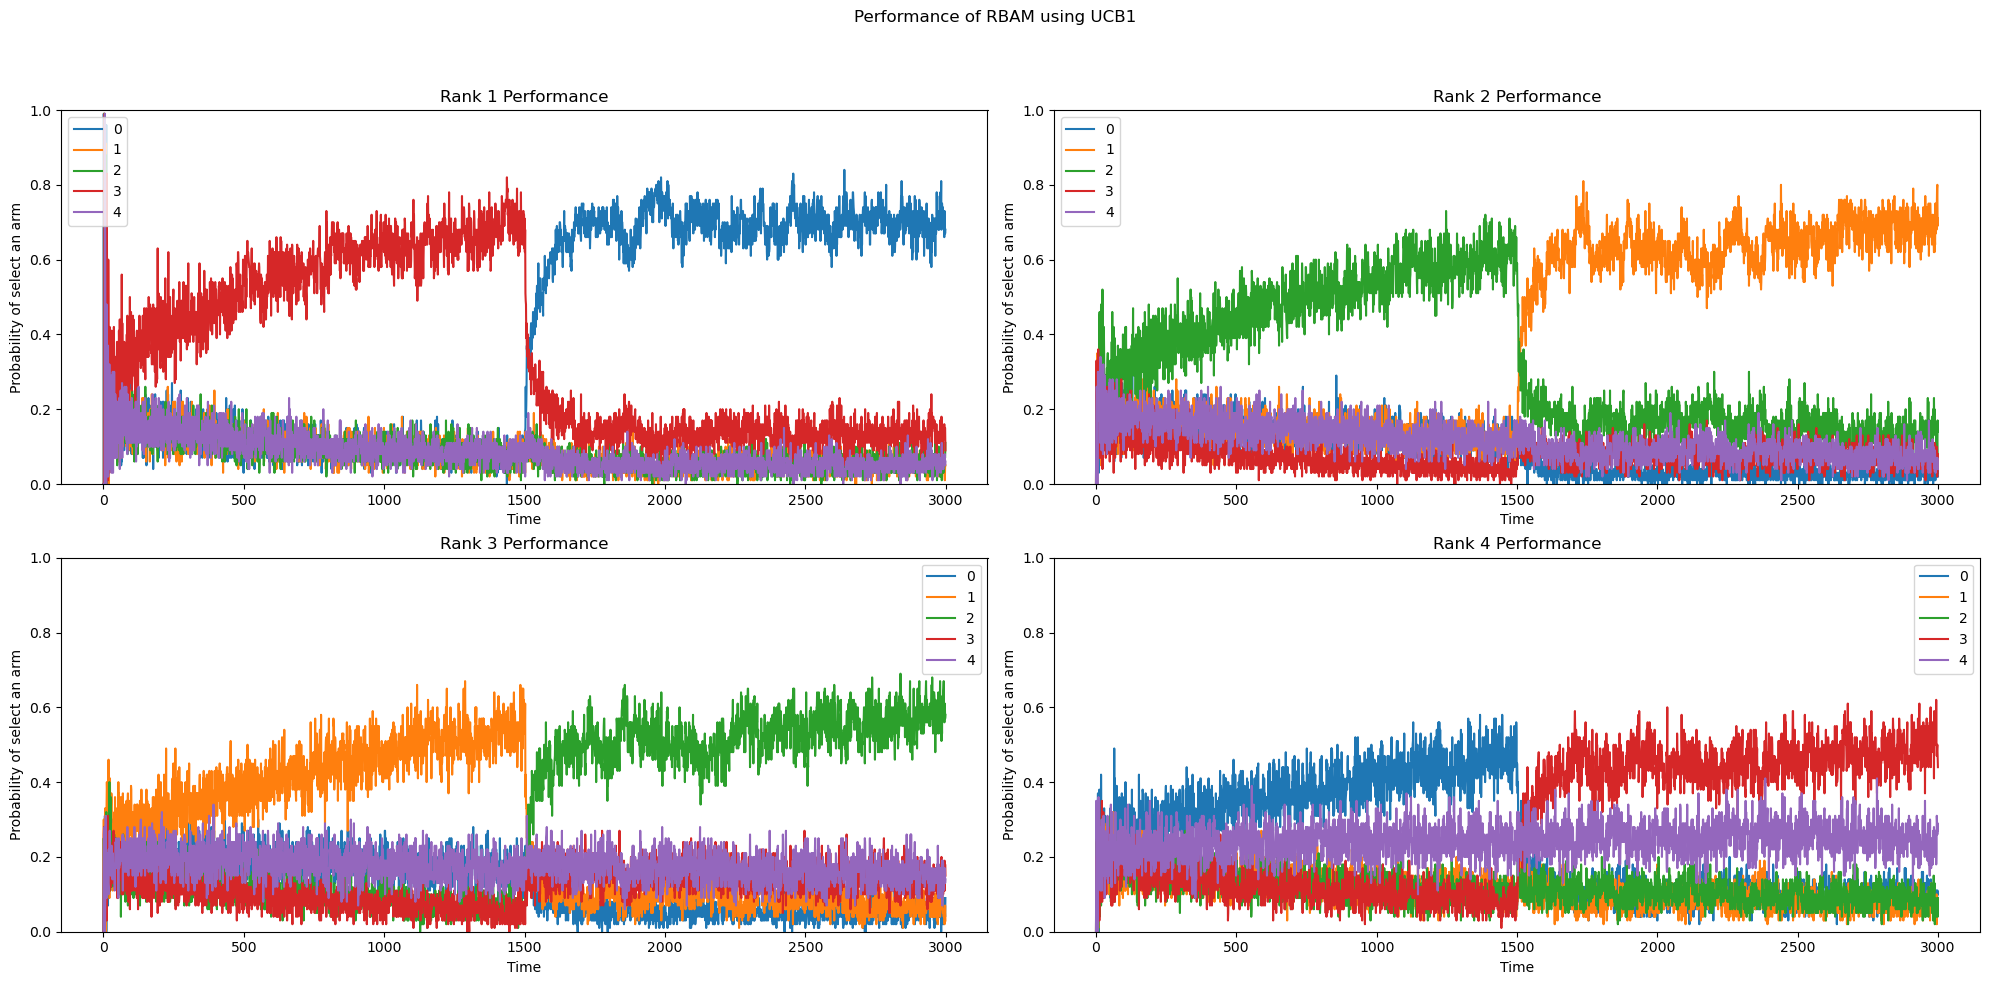

In [86]:
plot_results_proba('Thompsom Sampling', results_ths)
plot_results_proba('UCB1', results_ucb1)

In [88]:
print('Cumulative Rewards for UCB1: {}'.format(results_ucb1[3][-1]))
print('Cumulative Rewards for THS: {}'.format(results_ths[3][-1]))

Cumulative Rewards for UCB1: 1239.0399999999784
Cumulative Rewards for THS: 1418.1599999999742


In [89]:
%%time
reward_probabilities = {0: [[0.1, 0.1, 0.1, 0.9, 0.1], 
                            [0.1, 0.1, 0.9, 0.1, 0.1], 
                            [0.1, 0.9, 0.1, 0.1, 0.1], 
                            [0.9, 0.1, 0.1, 0.1, 0.1], 
                            [0.25, 0.25, 0.25, 0.25]],
                        
                       50: [[0.9, 0.1, 0.1, 0.1, 0.1], 
                             [0.1, 0.9, 0.1, 0.1, 0.1], 
                             [0.1, 0.1, 0.9, 0.1, 0.1], 
                             [0.1, 0.1, 0.1, 0.9, 0.1], 
                             [0.25, 0.25, 0.25, 0.25]]} #Rank weight.

number_of_pulls = 3000
number_of_simulation = 100

mcs = simulator.RankedMonteCarloSimulator()
results_ths = mcs.run("rba", algs.ThompsomSampling, reward_probabilities, number_of_simulation, number_of_pulls)
results_ucb1 = mcs.run("rba", algs.UCB1, reward_probabilities, number_of_simulation, number_of_pulls)

CPU times: total: 50.7 s
Wall time: 50.7 s


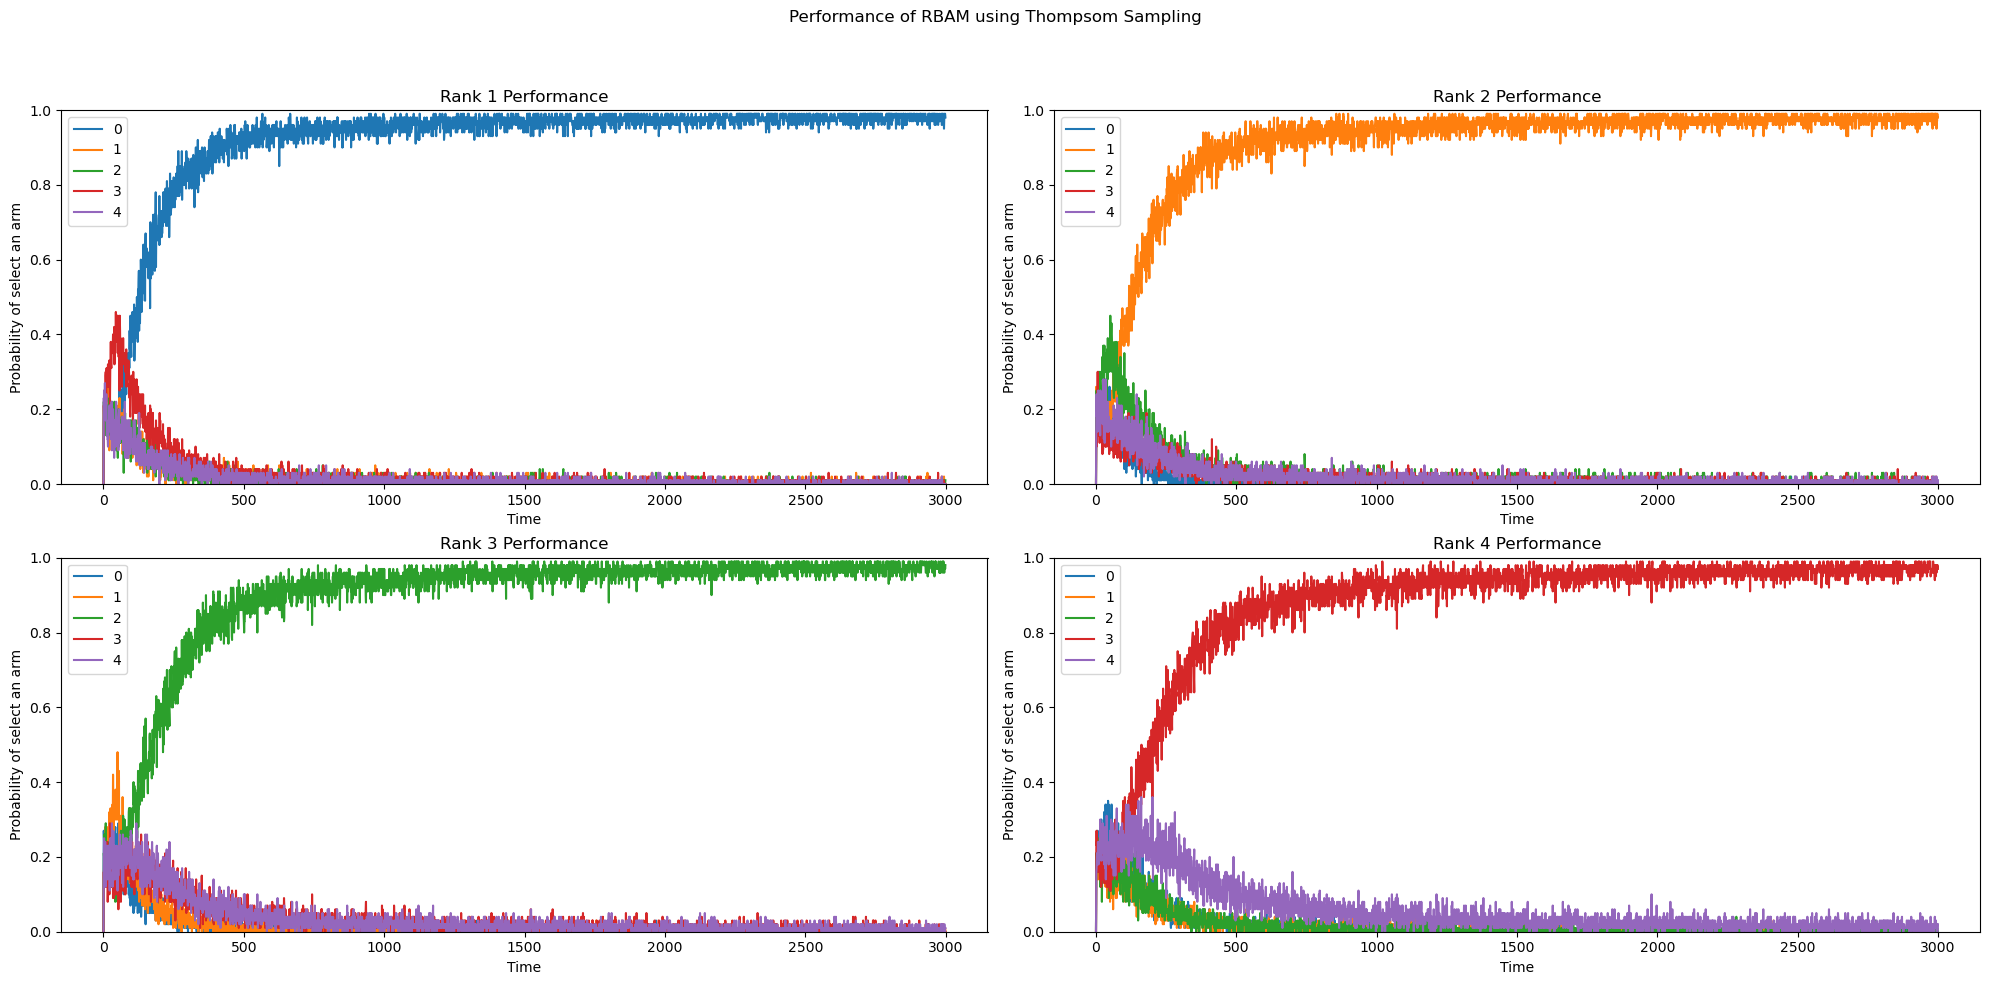

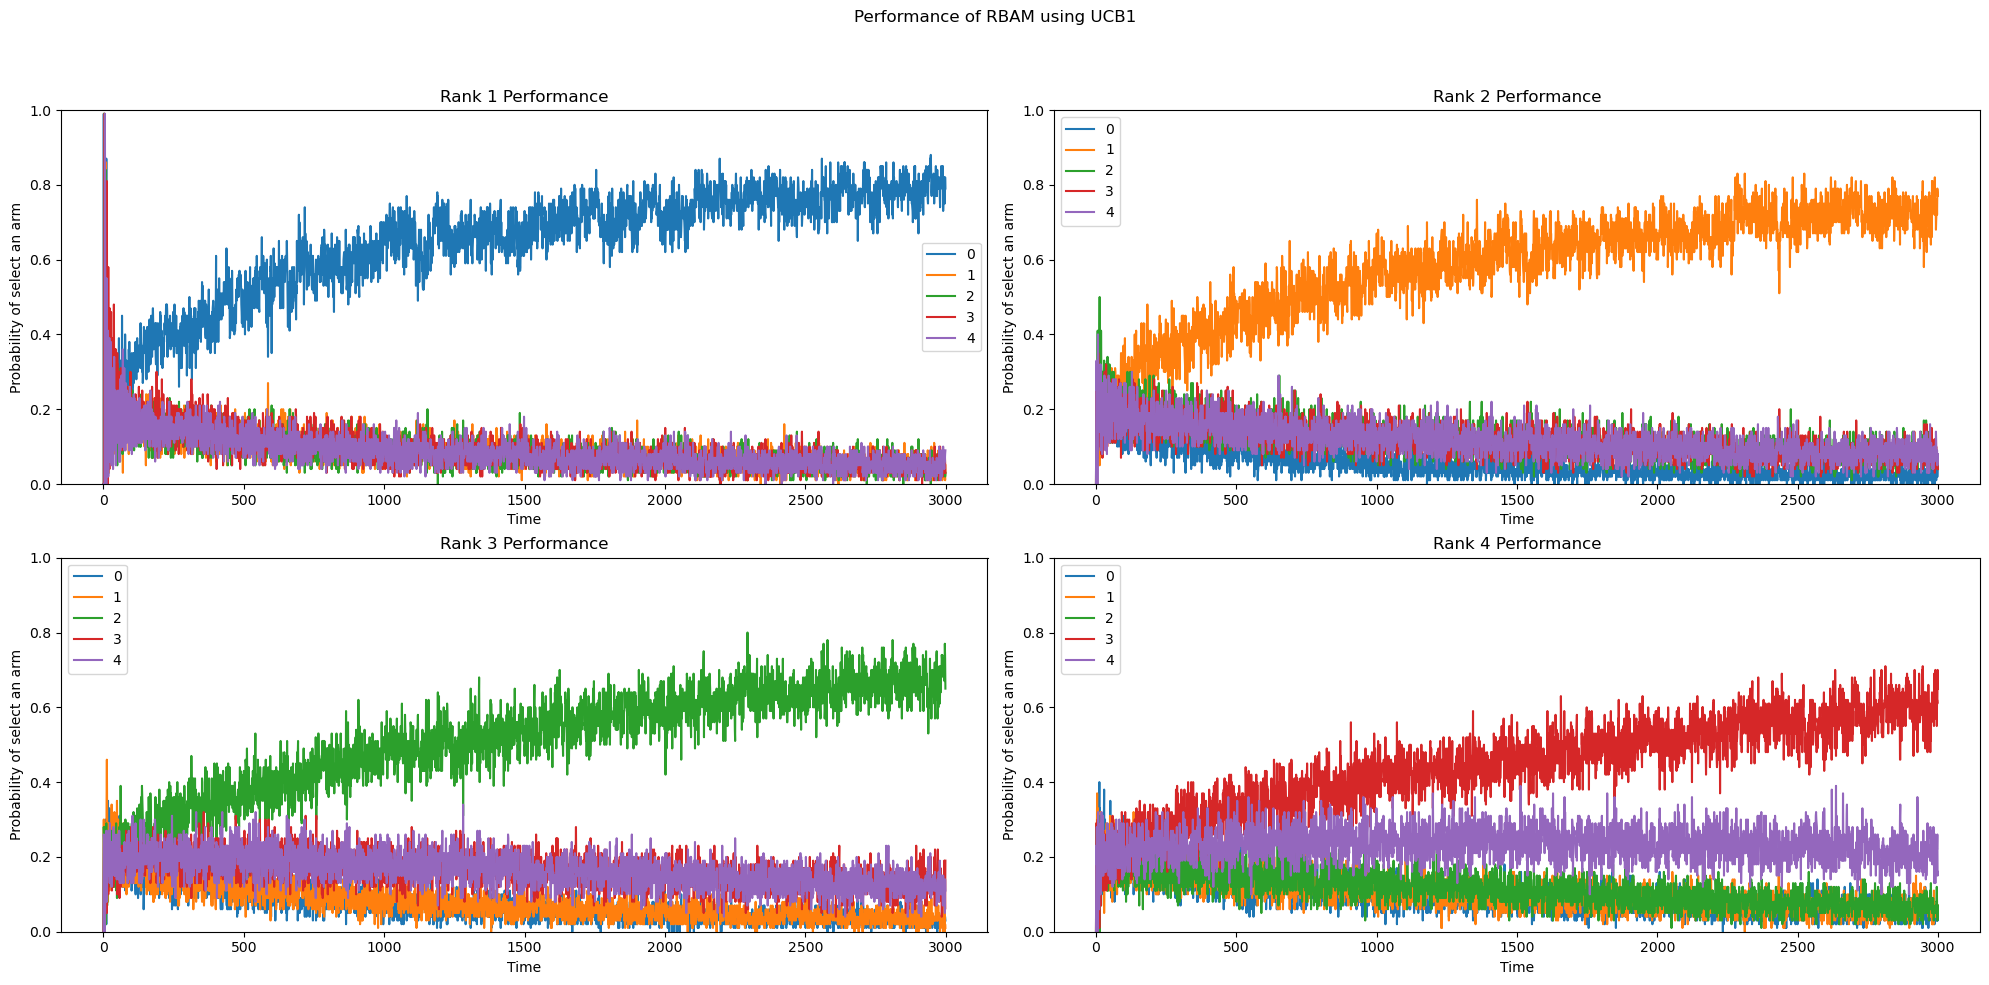

In [90]:
plot_results_proba('Thompsom Sampling', results_ths)
plot_results_proba('UCB1', results_ucb1)

In [91]:
print('Cumulative Rewards for UCB1: {}'.format(results_ucb1[3][-1]))
print('Cumulative Rewards for THS: {}'.format(results_ths[3][-1]))

Cumulative Rewards for UCB1: 1285.7399999999768
Cumulative Rewards for THS: 1776.350000000001


## 3. Movie recommendations

https://blog.insightdatascience.com/multi-armed-bandits-for-dynamic-movie-recommendations-5eb8f325ed1d

https://github.com/brian-c-ogorman/ABanditTesting

## Как в ivi персонализируют главную страницу с помощью многоруких бандитов

https://www.youtube.com/watch?v=VDhwkOi5Yvo&t=2663s

## Reinforcement Learning for Search

https://www.youtube.com/watch?v=oVkD-2xbqKM